In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline

### Part 1, fully connected feed-forward network

In [3]:
df = pd.read_csv('data/Tree_Data.csv')
df_clean = df.drop(['No',
                    'Light_Cat',
                    'Core',
                    'PlantDate',
                    'Adult',
                    'EMF',
                    'Census',
                    'Harvest',
                    'Alive',
                    'Time'],axis = 1)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)
df_clean['Plot'] = df_clean['Plot'].astype('object')
# df_clean.info()
df_clean.head()

,Plot,Subplot,Species,Light_ISF,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,Phenolics,Lignin,NSC,Event
0,1,C,Acer saccharum,0.106,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.00,-0.56,13.86,12.15,1.0
1,1,C,Quercus alba,0.106,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,15.82,5.19,20.52,19.29,0.0
2,1,C,Quercus rubra,0.106,Prunus serotina,Non-Sterile,Heterospecific,EMF,AMF,24.45,3.36,24.74,15.01,1.0
3,7,D,Acer saccharum,0.080,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.23,-0.71,14.29,12.36,1.0
4,14,A,Acer saccharum,0.060,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,21.15,-0.58,10.85,11.20,1.0


In [4]:
preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
)

X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(X_train).toarray()
X_test = preprocessing.transform(X_test).toarray()

y_train, y_test = y_train.values, y_test.values

print(f"Train data shape = {X_train.shape}, train target shape = {y_train.shape}")
print(f"Test data shape = {X_test.shape}, test target shape = {y_test.shape}")

Train data shape = (2225, 49), train target shape = (2225, 1)
Test data shape = (557, 49), test target shape = (557, 1)


In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
          batch_size=32, epochs=30)

Epoch 1/30
70/70 [==============================] - 2s 5ms/step - loss: 3.7462 - accuracy: 0.4391 - val_loss: 1.8892 - val_accuracy: 0.4309
Epoch 2/30
70/70 [==============================] - 0s 2ms/step - loss: 1.4325 - accuracy: 0.4773 - val_loss: 0.9707 - val_accuracy: 0.4794
Epoch 3/30
70/70 [==============================] - 0s 2ms/step - loss: 0.9112 - accuracy: 0.5227 - val_loss: 0.8009 - val_accuracy: 0.5368
Epoch 4/30
70/70 [==============================] - 0s 2ms/step - loss: 0.7787 - accuracy: 0.5560 - val_loss: 0.7533 - val_accuracy: 0.5619
Epoch 5/30
70/70 [==============================] - 0s 2ms/step - loss: 0.7357 - accuracy: 0.5820 - val_loss: 0.7102 - val_accuracy: 0.6068
Epoch 6/30
70/70 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.6144 - val_loss: 0.6720 - val_accuracy: 0.6463
Epoch 7/30
70/70 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.6463 - val_loss: 0.6415 - val_accuracy: 0.6607
Epoch 8/30
70/70 [==

#### Custom perceptron from scratch

In [7]:
from my_perceptron import My_Perceptron

In [8]:
neurons = [32, 8, 1]
functions = ['sigmoid', 'sigmoid', 'default']
model1 = My_Perceptron(n_neurons=neurons, act_func=functions, input_len=X_train.shape[1])
model1.fit(X_train, y_train, 90, 0.1)
y_pred = model1.predict(X_test)

In [9]:
acc = np.sum(np.where(np.where(y_pred > 0.5, 1, 0) == y_test, 1, 0)) / len(y_pred)
print(f'Accuracy = {round(acc, 2)}')

Accuracy = 0.85


### CNN

In [40]:
import tensorflow_datasets as tfds

In [41]:
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', 
                                         split=['train[:80%]', 'train[80%:]'],
                                         with_info=True,
                                         as_supervised=True)

Text(0.5, 1.0, 'class = 1')

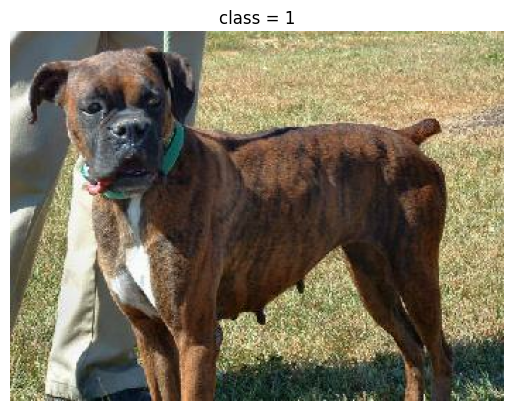

In [42]:
image, label = next(iter(ds_train.take(1)))
plt.imshow(image)
plt.axis('off')
plt.title(f"class = {label.numpy()}")

In [43]:
def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)


In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [47]:
model.fit(ds_train, validation_data=ds_test, epochs=5)

Epoch 1/5
291/291 [==============================] - 23s 72ms/step - loss: 0.6223 - accuracy: 0.6474 - val_loss: 0.5667 - val_accuracy: 0.7087
Epoch 2/5
291/291 [==============================] - 25s 85ms/step - loss: 0.5380 - accuracy: 0.7312 - val_loss: 0.5068 - val_accuracy: 0.7554
Epoch 3/5
291/291 [==============================] - 27s 92ms/step - loss: 0.4986 - accuracy: 0.7592 - val_loss: 0.5206 - val_accuracy: 0.7395
Epoch 4/5
291/291 [==============================] - 27s 91ms/step - loss: 0.4683 - accuracy: 0.7768 - val_loss: 0.4678 - val_accuracy: 0.7754
Epoch 5/5
291/291 [==============================] - 29s 99ms/step - loss: 0.4440 - accuracy: 0.7944 - val_loss: 0.4604 - val_accuracy: 0.7775


#### Transfer learning

In [49]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [51]:
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(ds_train, validation_data=ds_test, epochs=2)

Epoch 1/2
291/291 [==============================] - 52s 164ms/step - loss: 0.4165 - accuracy: 0.8012 - val_loss: 0.3616 - val_accuracy: 0.8401
Epoch 2/2
291/291 [==============================] - 49s 168ms/step - loss: 0.3256 - accuracy: 0.8517 - val_loss: 0.3581 - val_accuracy: 0.8405


### RNN

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Reshape, TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [65]:
df = pd.read_csv('data/words.csv')
df = df.drop(['Unnamed: 0', 'count', 'hate_speech',
                    'offensive_language', 'neither'],axis = 1)
df = df[['tweet', 'class']]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Data preparation
df['tweet'] = df['tweet'].str.replace(r'^.*?:\s*', '', regex=True)
df_temp = df.copy()
df['tweet'] = df['tweet'].str.replace(r'@\w+', 'person', regex=True)
df['tweet'] = df['tweet'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()
df_temp['tweet'] = df_temp['tweet'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()
df['class'] = df['class'].replace(2, 0)

df.head()

,tweet,class
0,as a woman you shouldnt complain about cleanin...,0
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,1
2,you ever fuck a bitch and she start to cry you...,1
3,person she look like a tranny,1
4,the shit you hear about me might be true or it...,1


In [86]:
vocab_size = 5000
embedding_dim = 64
max_length = 20
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['class'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [67]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точність моделі на тетсовій вибірці: {accuracy:.2f}")

Epoch 1/2
620/620 [==============================] - 6s 7ms/step - loss: 0.3588 - accuracy: 0.8448 - val_loss: 0.3093 - val_accuracy: 0.8753
Epoch 2/2
155/155 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8739
Точність моделі на тетсовій вибірці: 0.87


#### Pretrained embeddings

In [85]:
import tensorflow_hub as hub

In [91]:
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], 
                                 dtype=tf.string, trainable=True)
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    SimpleRNN(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точність моделі на тестовій вибірці: {accuracy:.2f}")


Epoch 1/5
620/620 [==============================] - 5s 6ms/step - loss: 0.3549 - accuracy: 0.8421 - val_loss: 0.3015 - val_accuracy: 0.8767
Epoch 2/5
620/620 [==============================] - 4s 6ms/step - loss: 0.2549 - accuracy: 0.8992 - val_loss: 0.3465 - val_accuracy: 0.8681
Epoch 3/5
620/620 [==============================] - 4s 6ms/step - loss: 0.1960 - accuracy: 0.9240 - val_loss: 0.3363 - val_accuracy: 0.8616
Epoch 4/5
620/620 [==============================] - 4s 6ms/step - loss: 0.1364 - accuracy: 0.9468 - val_loss: 0.4119 - val_accuracy: 0.8590
Epoch 5/5
155/155 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.8590
Точність моделі на тестовій вибірці: 0.86
